# Players encounters anomalies with SageMaker Random Cut Forests

***Unsupervised anomaly detection on timeseries data a Random Cut Forest algorithm.***

---

1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Training](#Training)
1. [Inference](#Inference)
1. [Epilogue](#Epilogue)

# Introduction
***

Amazon SageMaker Random Cut Forest (RCF) is an algorithm designed to detect anomalous data points within a dataset. 
In this example we are going to detect players moves during encounters in game sessions events. 

In this notebook, we will use the SageMaker RCF algorithm to train an RCF model on a banchmark conducted based on tpy game which records players moves over the course of six weeks gameplay. We will then use this model to predict anomalous events by emitting an "anomaly score" for each data point. The main goals of this notebook are,

* to learn how to obtain, transform, and store data for use in Amazon SageMaker;
* to create an AWS SageMaker training job on a data set to produce an RCF model,
* use the RCF model to perform inference with an Amazon SageMaker endpoint.

More about RCF please check out the [SageMaker RCF Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html).

# Setup

***

*This notebook was created and tested on an ml.m4.xlarge notebook instance.*

Our first step is to setup our AWS credentials so that AWS SageMaker can store and access training data and model artifacts. We also need some data to inspect and to train upon.

## Select Amazon S3 Bucket

We first need to specify the locations where we will store our training data and trained model artifacts. ***This is the only cell of this notebook that you will need to edit.*** In particular, we need the following data:

* `bucket` - An S3 bucket accessible by this account.
* `prefix` - The location in the bucket where this notebook's input and output data will be stored. (The default value is sufficient.)

In [30]:
import boto3
import botocore
import sagemaker
import sys


bucket = 'percona2020-player-events'   # <--- specify a bucket you have access to
prefix = 'sagemaker/rcf-benchmarks'
execution_role = sagemaker.get_execution_role()


# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

Training input/output will be stored in: s3://percona2020-player-events/sagemaker/rcf-benchmarks


We curated the csv file using curate scripts `curate.sh` and `curate.py`. Load the results file and observe before training and exported the data to `players_cheat_model/player_encounters-full-curated.csv`

In [1]:
%%time

import pandas as pd
import urllib.request
import boto3

data_filename = 'player_encounters-full-curated.csv'
data_objectname = 'players_cheat_model/player_encounters-full-curated.csv'
data_source = 'percona2020-player-events'


s3 = boto3.client('s3')
s3.download_file(data_source, data_objectname, data_filename)

player_data = pd.read_csv(data_filename, delimiter=',')
print(player_data.columns)

Index(['playerx', 'playerz', 'quadrant', 'sector', 'event'], dtype='object')
CPU times: user 1min 24s, sys: 18.5 s, total: 1min 42s
Wall time: 1min 45s


Before training any models it is important to inspect our data, first. Perhaps there are some underlying patterns or structures that we could provide as "hints" to the model or maybe there is some noise that we could pre-process away. The raw data looks like this:

In [2]:
player_data.head()

,playerx,playerz,quadrant,sector,event
0,199.0827,49.08284,Quadrant 3,Sector 1 -2,TraverseSector
1,178.2321,146.22680,Quadrant 3,Sector 0 0,TraverseSector
2,186.6547,-115.94910,Quadrant 1,Sector 0 0,EventResponseWormholeAnomaly
3,178.9562,-116.42950,Quadrant 1,Sector 0 0,EventResponseWormholeAnomaly
4,185.8585,-103.28220,Quadrant 1,Sector 0 0,EventResponseWormholeAnomaly


In [3]:
import csv
import sys
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
integer_quadrant_encoded = label_encoder.fit_transform(player_data.quadrant)
player_data["quadrant_encoded"]=integer_quadrant_encoded

integer_sector_encoded = label_encoder.fit_transform(player_data.sector)
player_data["sector_encoded"]=integer_sector_encoded

integer_event_encoded = label_encoder.fit_transform(player_data.event)
player_data["event_encoded"]=integer_event_encoded

player_data.head()

,playerx,playerz,quadrant,sector,event,quadrant_encoded,sector_encoded,event_encoded
0,199.0827,49.08284,Quadrant 3,Sector 1 -2,TraverseSector,3,25,7
1,178.2321,146.22680,Quadrant 3,Sector 0 0,TraverseSector,3,21,7
2,186.6547,-115.94910,Quadrant 1,Sector 0 0,EventResponseWormholeAnomaly,1,21,3
3,178.9562,-116.42950,Quadrant 1,Sector 0 0,EventResponseWormholeAnomaly,1,21,3
4,185.8585,-103.28220,Quadrant 1,Sector 0 0,EventResponseWormholeAnomaly,1,21,3


The folowing printouts help us to determine the encoding strategy. We apply the same strategy in the RDS side as we use it for calling the model using aurora_ml. We also use the `.size` method to determine we have only numbers in the data set. 

In [6]:
quadrant = player_data.groupby('quadrant_encoded').size()
print(quadrant)
sector = player_data.groupby('sector_encoded').size()
print(sector)
event = player_data.groupby('event_encoded').size()
print(event)

quadrant_encoded
0     3837916
1    28939141
2    29053511
3     3495932
dtype: int64
event_encoded
0        7852
1     9643885
2     5581043
3     8987499
4      116480
5     3499828
6     3437154
7    34052759
dtype: int64


In [7]:
player_data=player_data.drop('event',axis=1)
player_data=player_data.drop('quadrant',axis=1)
player_data=player_data.drop('sector',axis=1)
player_data.head()

,playerx,playerz,quadrant_encoded,sector_encoded,event_encoded
0,199.0827,49.08284,3,25,7
1,178.2321,146.22680,3,21,7
2,186.6547,-115.94910,1,21,3
3,178.9562,-116.42950,1,21,3
4,185.8585,-103.28220,1,21,3


In [8]:
print(player_data.columns)
player_data[['playerx','playerz','quadrant_encoded','sector_encoded','event_encoded']].describe()

Index(['playerx', 'playerz', 'quadrant_encoded', 'sector_encoded',
       'event_encoded'],
      dtype='object')


,playerx,playerz,quadrant_encoded,sector_encoded,event_encoded
count,6.532650e+07,6.532650e+07,6.532650e+07,6.532650e+07,6.532650e+07
mean,-4.124771e-01,-5.616098e-01,1.493023e+00,1.505362e+01,4.970812e+00
std,1.636912e+02,1.637119e+02,6.888253e-01,1.016202e+01,2.413060e+00
min,-2.927359e+02,-2.928427e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,-1.493577e+02,-1.506637e+02,1.000000e+00,5.000000e+00,3.000000e+00
50%,-1.826301e+01,-1.612999e+01,1.000000e+00,1.800000e+01,7.000000e+00
75%,1.501168e+02,1.496264e+02,2.000000e+00,2.400000e+01,7.000000e+00
max,2.927549e+02,2.927474e+02,3.000000e+00,3.500000e+01,7.000000e+00


In [9]:
features_of_players = pd.DataFrame({'quadrant': player_data['playerx'], 'playerz': player_data['playerz']})

features_of_players.head()

,quadrant,playerz
0,199.0827,49.08284
1,178.2321,146.22680
2,186.6547,-115.94910
3,178.9562,-116.42950
4,185.8585,-103.28220


Let's take a look at a plot of the data.

Lets look at perceiving patterns. 

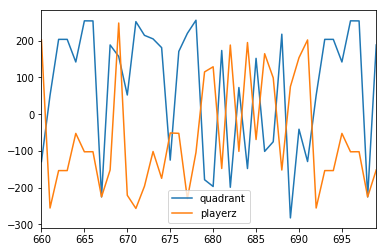

In [23]:
features_of_players[660:700].plot()

Removing playerguid before training. 

In [ ]:
features_of_players[328800:328816]

# Training

***

Next, we configure a SageMaker training job to train the Random Cut Forest (RCF) algorithm on the taxi cab data.

## Hyperparameters

Particular to a SageMaker RCF training job are the following hyperparameters:

* **`num_samples_per_tree`** - the number randomly sampled data points sent to each tree. As a general rule, `1/num_samples_per_tree` should approximate the the estimated ratio of anomalies to normal points in the dataset.
* **`num_trees`** - the number of trees to create in the forest. Each tree learns a separate model from different samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.
* **`feature_dim`** - the dimension of each data point.

In addition to these RCF model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role. Note that,

* Recommended instance type: `ml.m4`, `ml.c4`, or `ml.c5`
* Current limitations:
  * The RCF algorithm does not take advantage of GPU hardware.

In [11]:
print(player_data.values.reshape(-1,5))


[[ 199.0827    49.08284    3.        25.         7.     ]
 [ 178.2321   146.2268     3.        21.         7.     ]
 [ 186.6547  -115.9491     1.        21.         3.     ]
 ...
 [-107.2072   107.2072     2.        18.         1.     ]
 [-140.7918   125.         2.        18.         1.     ]
 [-150.0805   117.0529     2.         0.         1.     ]]


In [7]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
#rcf.fit(rcf.record_set(player_data.value.as_matrix().reshape(-1,1)))

rcf.fit(rcf.record_set(player_data.values.reshape(-1,5)))
job_name = rcf.latest_training_job.job_name
print("Training job: %s" % job_name)



2020-04-22 04:44:48 Starting - Starting the training job...
2020-04-22 04:44:50 Starting - Launching requested ML instances......
2020-04-22 04:45:52 Starting - Preparing the instances for training...
2020-04-22 04:46:39 Downloading - Downloading input data............
2020-04-22 04:48:37 Training - Downloading the training image..Docker entrypoint called with argument(s): train
/opt/amazon/lib/python2.7/site-packages/scipy/_lib/_numpy_compat.py:10: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing.nosetester import import_nose
/opt/amazon/lib/python2.7/site-packages/scipy/stats/morestats.py:12: DeprecationWarning: Importing from numpy.testing.decorators is deprecated, import from numpy.testing instead.
  from numpy.testing.decorators import setastest
[04/22/2020 04:49:00 INFO 139928461305664] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: 

# Inference

***

A trained Random Cut Forest model does nothing on its own. We now want to use the model we computed to perform inference on data. In this case, it means computing anomaly scores from input time series data points.

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up. We recommend using the `ml.c5` instance type as it provides the fastest inference time at the lowest cost.

In [8]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

---------------!

Congratulations! You now have a functioning SageMaker RCF inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console and selecting the endpoint matching the endpoint name, below: 

In [9]:
print('Endpoint name: {}'.format(rcf_inference.endpoint))

Endpoint name: randomcutforest-2020-04-22-04-44-48-664


## Data Serialization/Deserialization

We can pass data in a variety of formats to our inference endpoint. In this example we will demonstrate passing CSV-formatted data. Other available formats are JSON-formatted and RecordIO Protobuf. We make use of the SageMaker Python SDK utilities `csv_serializer` and `json_deserializer` when configuring the inference endpoint.

In [27]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

Let's pass the training dataset, in CSV format, to the inference endpoint so we can automatically detect the anomalies we saw with our eyes in the plots, above. Note that the serializer and deserializer will automatically take care of the datatype conversion from Numpy NDArrays.

For starters, let's only pass in the first six datapoints so we can see what the output looks like.

In [34]:
print(player_data[:2])
player_data_numpy = player_data.values.reshape(-1,6)
print(player_data_numpy[:2])
results = rcf_inference.predict(player_data_numpy[:2])
print(results)

    playerx   playerz  quadrant  sector1  sector2  eventname_encoded
0  100.2216 -151.1082         1       -2        0                  7
1  100.2742 -151.3711         1       -1        0                  7
[[ 100.2216 -151.1082    1.       -2.        0.        7.    ]
 [ 100.2742 -151.3711    1.       -1.        0.        7.    ]]
{'scores': [{'score': 0.6370093232}, {'score': 0.6410381801}]}


## Computing Anomaly Scores

Now, let's compute and plot the anomaly scores from the entire taxi dataset.

In [ ]:
results = rcf_inference.predict(player_data_numpy[:100])
scores = [datum['score'] for datum in results['scores']]
print(scores)

## Stop and Delete the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To do so execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable `endpoint_name`, and select "Delete" from the "Actions" dropdown menu. 

In [ ]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)